In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

# 第26章 GARCH模型

## 26.1 資產收益率的波動率與 ARCH 效應

我們在上一章結尾處提到，無法排除加權股價指數日收益率序列是白雜訊過程的可能，因此用 ARMA 模型對其建模是不科學的。既然如此，那是否就意味著我們無法從過去收益率序列提取資訊呢？學者們對金融時間序列（特別是資產收益率序列）深入挖掘，發現了幾個普遍的現象：

* 一組時間序列本身可能只有非常微弱的自相關性，而這組時間序列的函數（例如取平方、絕對值等）呈現很強的自相關性。

* 有些資產收益率序列的條件變異數（Conditional Variance）會隨著時間發生改變，也就是呈現條件異質變異數（Conditional Heteroskedasticity）的特徵。

* 資產收益率序列的波動會有持續的現象，即大波動跟著大波動，小波動伴隨著小波動，也就是波動叢聚（Volatility Clustering）現象。

* 許多資產收益率序列，並不服從常態分佈，其極端值較多、具有厚尾（Heavy Tail）現象。

因此統計、計量學家想方設法建立模型來捕捉時間序列的上述現象，這就是 ARCH 和 GARCH 模型誕生的過程。從 ARCH（AutoRegressive Conditional Heteroskedasticity）、GARCH（Generalized AutoRegressive Conditional Heteroskedasticity）模型的名字可以看出，這兩類模型主要用來刻畫時間序列波動性（也就是條件變異數）統計規律的模型。

在金融領域，對收益率序列的波動建模預測是非常有意義的。首先看看期權交易的例子，著名的 Black-Scholes-Merton 歐式看漲期權定價公式中就包含波動性項。一般而言，波動性越高，則定價公式計算得出的期權價格也越高。因此，精確的預測波動性則對期權價格的預測至關重要。其次，經典的 Markowitz 均值－變異數框架下的資產配置理論中，波動性也扮演了重要角色，資產波動性的準確性直接影響利用該資產配置理論選取的投資組合表現的好壞。另外，對於給定時間序列，對其波動性的適當建模可以改進該時間序列參數估計的有效性以及區間預測的精確度。最後，對波動性建模最直接的需要可能在於波動性本身已經成為一種金融工具並在美國芝加哥期權交易所交易。這些例子表明，對波動性建模在金融領域有其重要性。下面我們將介紹 ARCH 模型和 GARCH 模型的主要思想。

## 26.2 ARCH 模型和 GARCH 模型

### 26.2.1 ARCH 模型

ARCH 模型的全稱為自我相關條件異質變異數模型（Autoregressive Conditional Heteroskedastic Model），經常簡稱為條件異質變異數模型。它是 Engle 在 1982 年分析英國通貨膨脹率序列時提出的殘差平方自我迴歸模型。ARCH 模型主要是用來刻畫波動性的統計特徵，因此我們先要弄清楚如何衡量波動性。一般先假設收益率序列 $\{y_t\}$ 滿足某個均數方程式，例如 AR(p)、MA(q) 或 ARMA(p,q) 模型，這裡用簡單的 AR(1) 模型：

$$y_t=a_0+a_1y_{t-1}+\varepsilon_t$$

收益率 $y_t$ 的波動性（條件變異數）就可以用殘差項 $\varepsilon_t$ 的波動來刻畫，

$$\mathrm{Var}(y_t|y_{t-1})=\mathrm{Var}(\varepsilon_t|y_{t-1})$$

波動叢是指大波動跟隨大波動、小波動跟隨小波動，也就是說現期的波動會跟之前的波動有關，所以一個很自然的想法就是令 $\varepsilon_t$ 的條件變異數與過去殘差項的平方有關。具體的，一個 ARCH(p) 模型可以表達為：

$$
\begin{split}
\varepsilon_t&=\sigma_t u_t\\
\sigma_t^2&=\alpha_0+\alpha_1\varepsilon_{t-1}^2+...+\alpha_p\varepsilon_{t-p}^2
\end{split}
$$

其中 $\{u_t\}$ 是均值為 0、變異數為 1 的獨立同分佈隨機變數序列，即 $u_t\sim \mathit{IID}(0,1);\alpha_0>0,\alpha_i\ge 0$，且假定 $\alpha_i$ 滿足一定條件使得 $\varepsilon_t$ 的無條件變異數有限，即 $\mathrm{E}(\varepsilon_t^2)<\infty$。這樣我們可以計算 $\varepsilon_t$ 的條件均值（Conditional Mean）為：

$$\mathrm{E}(\varepsilon_t|\mathrm{F}^{t-1})=\sigma_t\mathrm{E}(u_t|\mathrm{F}^{t-1})=\sigma_t\mathrm{E}(u_t)=0$$

其條件變異數為：

\begin{align}
\mathrm{E}(\varepsilon_t^2|\mathrm{F}^{t-1})&=\sigma_t^2\mathrm{E}(u_t^2|\mathrm{F}^{t-1})=\sigma_t^2\mathrm{E}(u_t^2)=\sigma_t^2\nonumber\\
&=\alpha_0+\alpha_1\varepsilon_{t-1}^2+...+\alpha_p\varepsilon_{t-p}^2\label{eq:26.7}\\
\end{align}

從式 (\ref{eq:26.7}) 可以看出，滿足 ARCH(p) 模型的序列之波動（條件變異數）與其過去 $p$ 期的波動有關，而且會隨著時間改變，這就是「自我相關條件異質變異數」這幾個字的涵義，ARCH 模型刻畫的這種現象被稱作 ARCH 效應。可以驗證 $\{\varepsilon_t\}$ 是白雜訊過程，滿足：

$$
\begin{split}
\mathrm{E}(\varepsilon_t)&=\mathrm{E}[\mathrm{E}(\varepsilon_t|\mathrm{F}^{t-1})]=0\\
\mathrm{Var}(\varepsilon_t)&=\mathrm{E}[\mathrm{E}(\varepsilon_t^2|\mathrm{F}^{t-1})]=\mathrm{E}(\sigma_t^2)\\
&=\alpha_0+\alpha_1\mathrm{E}(\varepsilon_{t-1}^2)+...+\alpha_p\mathrm{E}(\varepsilon_{t-p}^2)\\
&=\frac{\alpha_0}{1-\alpha_1-...-\alpha_p}\\
\mathrm{Cov}(\varepsilon_t\varepsilon_{t-j})&=\mathrm{E}(\varepsilon_t\varepsilon_{t-j})=\mathrm{E}[\sigma_t\sigma_{t-j}u_{t-j}\mathrm{E}(u_t|\mathrm{F}^{t-1})]=0
\end{split}
$$

而且 $\varepsilon_t$ 有自相關性、並可用 AR(p) 型刻畫，$\varepsilon_t$ 滿足厚尾現象，讀者有興趣可以自行驗證。綜合來看，ARCH(p) 模型很好地刻畫了資產收益率序列表現出來的特徵，不過需要注意的是，ARCH(p) 或 GARCH(p) 模型是完全單純的統計模型，它們只是捕捉到金融序列的特徵，而無法用來解譯金融序列為何有這些特徵。

ARCH(p) 模型的估計過程：

* 估計一個 ARCH 模型，首先我們需要設定一個合適的階次 $p$。為確立 ARCH(p) 模型中的階次，在檢定得知時間序列 $\{\varepsilon_t\}$ 確實存在顯著的 ARCH 效應的條件下，我們可以用 $\varepsilon_t$ 的偏自相關函數（PACF）來確定 $p$。

* 設定好階次後，為估計模型參數，我們常常假定 $u_t$ 服從以下三種分布中的一種來進行估計：標準常態分佈、標準化的學生 $t$ 分佈和廣義誤差分佈。然後用最大似然估計（Maximum Likelihood）。

* 對模型進行參數估計後，我們需要檢定模型設定。最常見的檢定依賴於以下事實：一個正確設定的 ARCH 模型，標準化殘差 $\hat{u}_t=\dfrac{\hat\varepsilon_t}{\hat\sigma_t}$ 是獨立同分佈的隨機過程。因此 $\{\hat{u}_t\}$ 和 $\{\hat{u}_t^2\}$ 的 Ljung-Box 統計量可以分別用來檢定均值方程和波動性方程的正確性。

### 26.2.2 GARCH 模型

從前面介紹可以看到，ARCH 模型中波動性 $\sigma_t^2$ 僅與 $\varepsilon_t^2$ 的落後項有關，即 ARCH(p) 模型的實質是用殘差平方序列的 $p$ 階移動平均擬合當期條件變異數函數值，也就是說 ARCH(p) 模型是將 AR(p) 模型的思想用在估計條件變異數上。Bollerslev（1986）提出了 ARCH 模型的推廣形式，稱為廣義自我相關條件異質變異數模型（Generalized AutoRegressive Conditional Heteroskedastic Model），簡稱 GARCH  模型。GARCH(p,q) 類似於 ARCH(p,q) 的設定，認為時間序列每個時間點變數的波動性是最近 $p$ 個時間點殘差平方的線性組合，與最近 $q$ 個時問點變數波動性的線性組合加起來得到的：

$$
\begin{split}
\varepsilon_t&=\sigma_tu_t\\
\sigma_t^2&=\alpha_0+\sum_{i=1}^p\alpha_i\varepsilon_{t-i}^2+\sum_{j=1}^q\beta_j\sigma_{t-j}^2
\end{split}
$$

<span><sup>5</sup> 這個假設是否合理，從邏輯的角度而言並不重要，重點在於讀者視它為「有待驗證的假設（Refutable Hypothesis）」。</span>

其中，$\{u_t\}$ 是一個均值為 0，變異數為 1 的獨立同分佈隨機變數序列，即 $u_t\sim\mathit{IID}(0,1); \alpha_0>0,\alpha_i,\beta_j\ge 0,\sum_{i=1}^p\alpha_i+\sum_{j=1}^p<1$，且假定 $\alpha_i$ 與 $\beta_j$ 滿足一定條件使得 $\varepsilon_t$ 的條件變異數隨時間變化、無條件變異數有限。

令 $\eta_t=\varepsilon_t^2-\sigma_t^2=\sigma_t^2(u_t^2-1)$，在 ARCH 模型中我們已知：

$$\mathrm{VAR}(\varepsilon_t)=\mathrm{E}(\varepsilon_t^2)=\mathrm{E}(\sigma_t^2)$$

則

$$\mathrm{E}(\eta_t)=0$$

且對於 $j\ge 1$，

$$\mathrm{Cov}(\eta_t,\eta_{t-j})=\mathrm{E}(\eta_t\eta_{t-j})=\mathrm{E}\big[\sigma_t^2\sigma_{t-j}^2(u_t^2-1)(u_{t-j}^2-1)\big]=0$$

也就是說 $\eta_t$ 是個白雜訊過程。將 $\eta_t=\varepsilon_t^2-\sigma_t^2$ 改為 $\sigma_t^2=\varepsilon_t^2-\eta_t$ 並代入 $\varepsilon_t^2$ 中，規定當 $i>p$ 時 $\alpha_i=0$，且當 $j>s$ 時 $\beta_j=0$，可得：

$$
\begin{split}
\varepsilon_t^2&=\sigma_t^2+\varepsilon_t^2-\sigma_t^2\\
&=\alpha_0+\sum_{i=1}^p\alpha_i\varepsilon_{t-i}^2+\sum_{j=1}^q\beta_j(\varepsilon_{t-j}^2-\eta_{t-j})+\eta_t\\
&=\alpha_0+\left(\sum_{i=1}^p\alpha_i\varepsilon_{t-i}^2+\sum_{j=1}^q\beta_j\varepsilon_{t-j}^2\right)+\eta_t-\sum_{j=1}^q\beta_j\eta_{t-j}\\
&=\alpha_0+\sum_{i=1}^{\max(p,q)}(\alpha_i+\beta_i)\varepsilon_{t-i}^2+\eta_t-\sum_{j=1}^q\beta_j\eta_{t-j}
\end{split}
$$

前文提及，滿足 ARCH(p) 模型的序列 $\{\varepsilon_t\}$ 的變化序列 $\{\varepsilon_t^2\}$ 可用 AR(p) 模型刻畫，而 GARCH 模型相當於在變換後的 $\varepsilon_t^2$ 方程中添加了 MA 項（即 $\eta_t,\eta_{t-1},...,\eta_{t-j}$ 項），以作為 ARCH 模型的推廣。透過計算也可以得到 GARCH 模型中波動性聚集以及厚尾特徵，在此略過細節，有興趣的讀者可自行推導 GARCH 摸型的估計與 ARCH 模型類似，在假設擾動的分佈之後常採用條件最大似然估計，具體過程請參閱計量經濟學相關書籍。

ARCH 與 GARCH 模型的不足之處很類似。首先，這兩種模型都認為波動是對稱的，也就是不論何時，過去期的波動對現期間條件變異數的影響是相同的，而實證結果並非如此，例如有學者發現，當壞（好）訊息發布時，股票收益率的波動會增加（減小）。其次，兩個模型對參數的限制都較強，特別是高階模型，參數需要滿足的約束會非常複雜。最後，作為統計模型，兩個模型並沒有提供關於波動變化的更進一步的解譯而僅僅是擬合波動性變化的統計行為，要進一步理解波動性的動態變化還需要其他理論。

## 26.3 ARCH 效應檢定

對資產收益率序列 $\{y_t\}$ 建立波動性模型一般需要下列 5 個步驟：

1. 先檢定收益率序列 $\{y_t\}$ 是否是定態的時間序列，並對根據其相關性建立合適的均值方程（例如 ARMA 模型），說明收益率的 $y_t$ 如何隨時間演進。根據擬合的模型和實際值，可以得到殘差序列 $\{\hat\varepsilon_t\}$。

2. 對擬合的均值方程得到的殘差序列進行ARCH效應檢定，也就是檢定收益率圍繞著均值的偏差是否看起來時大時小，而並非幾乎同樣規模的匾差。檢定序列）是否具有ARCH效應有兩種常用方法。
   1. 用Ljung-Box 檢定殘差平方序列 $\{\hat\varepsilon_t^2\}$ 的自相關性，即將序列的平方值作為波動性的代理變數，若殘差平方序列有自相關性，則說明當期波動與過去期波動有關，初步判別序列 $\{\varepsilon_t\}$ 有 ARCH 效應
   2. 用 Engle（1982）提出的 Lagrange Multiplier 檢定（LM 檢定）。LM 檢定旳式子為：

\begin{equation}
\hat\varepsilon_t^2=\hat\alpha_0+\sum_{i=1}^p\hat\alpha_i\hat\varepsilon_{t-i}^2\label{eq:26.8}
\end{equation}

檢定的虛無假設為：序列 $\{\hat\varepsilon_t\}$ 無 ARCH 效應，即 $\alpha_i=0,i=1,...q$。對立假設為序列 $\{\hat\varepsilon_t\}$ 具有 ARCH 效應，即至少有一個 $\alpha_i$ 顯著不為 0。

3. 若上一步中 ARCH 效應在統計上顯著，也就是收益率關於其均值的偏差也有動態變化，那麼，我們就需要再設定一個波動性模型嘗試刻畫這種波動性的動態變化；

4. 對均值方程和波動性方程進行聯合估計，也就是假設實際資料服從前面設定的均值方程和波動性方程後，計算出均值方程和波動性方程中的參數的估計值是多少，參數估計的誤差是多少；

5. 檢定所擬合的模型，並在必要時進行改進。這一步非常重要，因為上一步中假定實際資料服從第 1 步設定的均值方程和第 3 步設定的波動性方程，然而這一假定並不一定合理。如果估計結果（特別是殘差）不滿足模型本身的假設，那麼模型的可用性就很值得懷疑。所以我們需要在估計完參數後對模型的假設再進行檢定。

下面，我們以加權股價指數為例來說明如何判斷是否具有 ARCH 效應。我們從加權股價指數 2014 年到 2016 年的日收益率序列的平方以及絕對值這兩個序列的圖形上來識別原序列是否具有 ARCH 效應。

              CO_ID            CoName        Date        ROI
Date                                                        
2014-01-02  Y9999       TSE Taiex      2014/01/02     0.0120
2014-01-02  TWN50       TW 50 INDEX    2014/01/02    -0.3534
2014-01-02  TM100    TW MID-CAP INDEX  2014/01/02     0.6243
2014-01-03  Y9999       TSE Taiex      2014/01/03    -0.7663
2014-01-03  TWN50       TW 50 INDEX    2014/01/03    -1.1200


array(['TSE Taiex    ', 'TW 50 INDEX  ', 'TW MID-CAP INDEX',
       'TWSE CG100 TR Index', 'Taiwan HC 100'], dtype=object)

Date
2014-01-02       0.0120
2014-01-03      -0.7663
2014-01-06      -0.5444
2014-01-07       0.1446
2014-01-08       0.5135
Name: ROI, dtype: object

Date
2016-12-26       0.3514
2016-12-27      -0.0139
2016-12-28       1.0114
2016-12-29      -0.5250
2016-12-30       1.0970
Name: ROI, dtype: object

D:\myProgram\Portable Python 3.6.5 x64 R2\App\Python\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


([], <a list of 0 Text xticklabel objects>)

Text(0.5, 1.0, 'Squared Daily Return of TW Taiex')

Text(0.5, 1.0, 'Absolute Daily Return of TW Taiex')

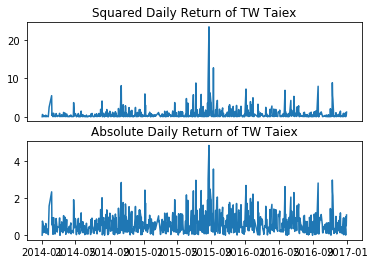

In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model

# 讀取指數收益率資料
indexRet = pd.read_csv('.\\PythonBook_code_data\\part4\\026\\index.csv',sep='\t')
indexRet.index=pd.to_datetime(indexRet.Date)
print(indexRet.head())

np.unique(indexRet.CoName)

# 讀取加權股價指數收益率指數資料
taiexRet=indexRet.loc[indexRet.CoName=='TSE Taiex    '].ROI
taiexRet.head()

taiexRet.tail()

# 轉換成folat型態
taiexRet = taiexRet.astype(np.float).dropna()

# 繪製收益率平方序列圖
plt.subplot(211)
plt.plot(taiexRet**2)
plt.xticks([])
plt.title('Squared Daily Return of TW Taiex')
plt.subplot(212)
plt.plot(np.abs(taiexRet))
plt.title('Absolute Daily Return of TW Taiex')

從圖 26.1 中可以大致觀察出加權股價指數收益率序列存在著很明顯的波動叢聚的現象。因此我們可以初步判斷出加權股價指數日收益率序列存在著 ARCH 效應。

圖26.1：加權股價指數收益率序列的平方與絕對值

接著我們用 LB 檢定來檢定收益率平方的自相關性（取 13 階落後）。

In [3]:
LjungBox=stattools.q_stat(stattools.acf(taiexRet**2)[1:13],len(taiexRet))
LjungBox[1][-1]

D:\myProgram\Portable Python 3.6.5 x64 R2\App\Python\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


1.449575599842014e-19

由於檢定的 $p$ 值明顯小於 0.05，我們可以拒絕加權股價指數收益率的方序列是白雜訊（無自相關）的虛無假設，推斷原序列（加權股價指數收益率序列）存在 ARCH 效應。

## 26.4 GARCH 模型建構

最常使用且通常也很適合金融時間序列的 GARCH 模型是 GARCH(1,1)。在 Python 中，我們可以使用 arch 套件來對 GARCH 模型進行建模。接下來，我們就以 2014-2016 年加權股價指數的收益率為研究對象，建立 GARCH 模型具體程式碼如下所示：

In [4]:
# 滙入 arch 套件中的 arch_model 模組
from arch import arch_model

# 設定模型
# arch_model 預設建立 GARCH(1,1) 模型
am=arch_model(taiexRet)

# 估計參數
# update_freqze=0 表示不匯出中間結果，只匯出最終結果
model = am.fit(update_freq=0)

print(model.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 895.0641468735382
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ROI   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -895.064
Distribution:                  Normal   AIC:                           1798.13
Method:            Maximum Likelihood   BIC:                           1816.53
                                        No. Observations:                  736
Date:                Sun, Mar 08 2020   Df Residuals:                      732
Time:                        23:36:30   Df Model:                            4
                                  Mean Model                                 
 

根據函數的傳回值，模型結果為：

$$r_t=-0.024+\varepsilon_t$$

其中

$$
\begin{split}
\varepsilon_t&=\sigma_tu_t\\
\sigma_t^2&=0.0451+0.0736\varepsilon_{t-1}^2+0.8636\sigma_{t-1}^2
\end{split}
$$